# Resnet50 with finetuned conv layers and data augmentation

In [2]:
%matplotlib inline  
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import bcolz
import random
import image
from importlib import reload
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras import backend as K
reload(image)

<module 'image' from '/home/nighturs/Projects/kaggle-galaxy-zoo/notebooks/image.py'>

In [ ]:
resnet_model = ResNet50(include_top=False, input_shape=(3, 224, 224))

Batch generator with data augmentation. Original ImageDataGenerator only supports labels with stric categories (either 0 or 1), so here we use modified generator that can return filename as label. Also instead of resizing images it can crop them leaving center (useful for galaxies).

Found 61478 images belonging to 1 classes.


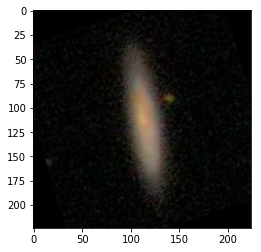

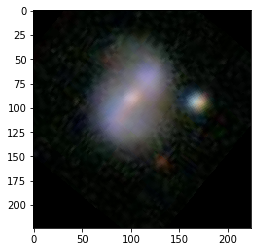

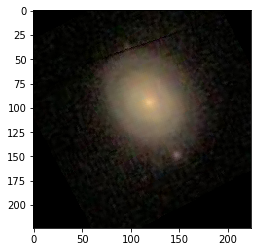

In [8]:
class AugmentedBatches():
    def __init__(self, dir, classes, batch_size=64, seed=123, apply_aug=True, shuffle=True, prep_input=None):
        if apply_aug:
            self.gen = image.ImageDataGenerator(fill_mode='constant', cval=0, 
                                           rotation_range=90, 
                                           width_shift_range=0.1, 
                                           height_shift_range=0.1,
                                           horizontal_flip=True,
                                           vertical_flip=True,
                                           preprocessing_function=prep_input)
        else: 
            self.gen = image.ImageDataGenerator(preprocessing_function=prep_input)
        self.it = self.gen.flow_from_directory(dir, class_mode='fname', 
                                               batch_size=batch_size, target_size=(224, 224), 
                                               seed=seed, should_crop=True, shuffle=shuffle)
        df = pd.read_csv('../data/training_solutions_rev1.csv')[['GalaxyID'] + classes]

        self.class_dict = {}
        for row in df.itertuples():
            self.class_dict[row.GalaxyID] = np.array(row[2:])

    def next(self):
        x, y = next(self.it)
        return x, np.array([self.class_dict[int(s.decode('UTF-8')[:-4])] for s in y])
    
    def __iter__(self):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)

aug_batches = AugmentedBatches('../data/train', ['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1',
           'Class2.2', 'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2',
           'Class5.1', 'Class5.2', 'Class5.3', 'Class5.4', 'Class6.1',
           'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3', 'Class8.1',
           'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
           'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
           'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
           'Class11.4', 'Class11.5', 'Class11.6'], batch_size=1, seed=64)
        
for i in range(3):
    plt.imshow(np.moveaxis(next(aug_batches)[0][0], 0, -1).astype(np.uint8))
    plt.show()

Finetune single sigmoid dense layer. RMSE turned out to be problematic in keras so use MSE. Because of the way keras calculates loss, it is safe to calculate RMSE as sqrt(MSE).

In [12]:
classes = ['Class1.1', 'Class1.2', 'Class1.3', 'Class2.1',
           'Class2.2', 'Class3.1', 'Class3.2', 'Class4.1', 'Class4.2',
           'Class5.1', 'Class5.2', 'Class5.3', 'Class5.4', 'Class6.1',
           'Class6.2', 'Class7.1', 'Class7.2', 'Class7.3', 'Class8.1',
           'Class8.2', 'Class8.3', 'Class8.4', 'Class8.5', 'Class8.6',
           'Class8.7', 'Class9.1', 'Class9.2', 'Class9.3', 'Class10.1',
           'Class10.2', 'Class10.3', 'Class11.1', 'Class11.2', 'Class11.3',
           'Class11.4', 'Class11.5', 'Class11.6']

x = Flatten()(resnet_model.output)
x = Dense(len(classes), activation='sigmoid')(x) 
model = Model(inputs=resnet_model.input, outputs=x)

for layer in model.layers[:-1]:
    layer.trainable= False
    
model.compile(optimizer='rmsprop', loss='mse', metrics =["accuracy"])

train_batches = AugmentedBatches('../data/train', classes, batch_size=64)
valid_batches = AugmentedBatches('../data/valid', classes, batch_size=256, apply_aug=False, shuffle=False)

np.random.seed(123)
model.fit_generator(train_batches, steps_per_epoch=train_batches.it.n / train_batches.it.batch_size, 
                    validation_data=valid_batches, 
                    validation_steps = valid_batches.it.n / valid_batches.it.batch_size, epochs=1)

Found 60578 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Epoch 1/1
947/946 [==============================] - 752s - loss: 0.0200 - acc: 0.5893 - val_loss: 0.0182 - val_acc: 0.6330


In [19]:
model.save('v2_finetuning_p1_ep1.h5')

Start finetuning conv layers too

In [26]:
for layer in model.layers[:78]:
    layer.trainable = False
for layer in model.layers[78:]:
    layer.trainable = True
    
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001), loss='mse', metrics =["accuracy"])

np.random.seed(123)
model.fit_generator(train_batches, steps_per_epoch=train_batches.it.n / train_batches.it.batch_size, 
                    validation_data=valid_batches, 
                    validation_steps = valid_batches.it.n / valid_batches.it.batch_size, epochs=1)

Epoch 1/1
947/946 [==============================] - 1390s - loss: 0.0135 - acc: 0.7213 - val_loss: 0.0127 - val_acc: 0.7310


In [27]:
model.save('v2_finetuning_p2_ep1.h5')

In [28]:
model.fit_generator(train_batches, steps_per_epoch=train_batches.it.n / train_batches.it.batch_size, 
                    validation_data=valid_batches, 
                    validation_steps = valid_batches.it.n / valid_batches.it.batch_size, epochs=1)

Epoch 1/1
947/946 [==============================] - 1388s - loss: 0.0100 - acc: 0.7714 - val_loss: 0.0106 - val_acc: 0.7600


In [31]:
model.save('v2_finetuning_p2_ep2.h5')

Change optimizer to Adam

In [32]:
model.compile(optimizer='adam', loss='mse', metrics =["accuracy"])

model.fit_generator(train_batches, steps_per_epoch=train_batches.it.n / train_batches.it.batch_size, 
                    validation_data=valid_batches, 
                    validation_steps = valid_batches.it.n / valid_batches.it.batch_size, epochs=1)

Epoch 1/1
947/946 [==============================] - 1400s - loss: 0.0091 - acc: 0.7809 - val_loss: 0.0099 - val_acc: 0.7640


In [ ]:
model.save('v2_finetuning_p2_ep3.h5')

In [33]:
model.fit_generator(train_batches, steps_per_epoch=train_batches.it.n / train_batches.it.batch_size, 
                    validation_data=valid_batches, 
                    validation_steps = valid_batches.it.n / valid_batches.it.batch_size, epochs=1)

Epoch 1/1
947/946 [==============================] - 1401s - loss: 0.0086 - acc: 0.7874 - val_loss: 0.0090 - val_acc: 0.7800


In [36]:
model.save('v2_finetuning_p2_ep4.h5')

In [37]:
model.fit_generator(train_batches, steps_per_epoch=train_batches.it.n / train_batches.it.batch_size, 
                    validation_data=valid_batches, 
                    validation_steps = valid_batches.it.n / valid_batches.it.batch_size, epochs=1)

Epoch 1/1
947/946 [==============================] - 1400s - loss: 0.0082 - acc: 0.7965 - val_loss: 0.0090 - val_acc: 0.7820


In [38]:
model.save('v2_finetuning_p2_ep5.h5')

In [39]:
model.fit_generator(train_batches, steps_per_epoch=train_batches.it.n / train_batches.it.batch_size, 
                    validation_data=valid_batches, 
                    validation_steps = valid_batches.it.n / valid_batches.it.batch_size, epochs=1)

Epoch 1/1
947/946 [==============================] - 1405s - loss: 0.0081 - acc: 0.7985 - val_loss: 0.0084 - val_acc: 0.7970


In [40]:
model.save('v2_finetuning_p2_ep6.h5')

Now finetune whole NN

In [ ]:
for layer in model.layers:
    layer.trainable = True
    
model.compile(optimizer='adam', loss='mse', metrics =["accuracy"])

model.fit_generator(train_batches, steps_per_epoch=train_batches.it.n / train_batches.it.batch_size, 
                    validation_data=valid_batches, 
                    validation_steps = valid_batches.it.n / valid_batches.it.batch_size, epochs=1)

Epoch 1/1
608/946 [==================>...........] - ETA: 816s - loss: 0.0084 - acc: 0.7914

In [47]:
model.fit_generator(train_batches, steps_per_epoch=train_batches.it.n / train_batches.it.batch_size, 
                    validation_data=valid_batches, 
                    validation_steps = valid_batches.it.n / valid_batches.it.batch_size, epochs=1)

Epoch 1/1
947/946 [==============================] - 2296s - loss: 0.0076 - acc: 0.8026 - val_loss: 0.0076 - val_acc: 0.8070


In [50]:
model.save('v2_finetuning_p2_ep7.h5')

At this point validation loss got higher. v2_finetuning_p2_ep7 has 0.08815 kaggle public score.

In [51]:
model.fit_generator(train_batches, steps_per_epoch=train_batches.it.n / train_batches.it.batch_size, 
                    validation_data=valid_batches, 
                    validation_steps = valid_batches.it.n / valid_batches.it.batch_size, epochs=1)

Epoch 1/1
947/946 [==============================] - 2299s - loss: 0.0073 - acc: 0.8088 - val_loss: 0.0101 - val_acc: 0.8070


In [ ]:
Generate predictions for test data.

In [48]:
gen = image.ImageDataGenerator()
it = gen.flow_from_directory('../data/test', class_mode='fname', 
                            batch_size=128, target_size=(224, 224), 
                            seed=123, should_crop=True, shuffle=False)


predictions = model.predict_generator(it, it.n / it.batch_size)

df = pd.DataFrame(predictions)
df = df.rename(columns={k: v for k, v in enumerate(classes)})

df['GalaxyID'] = [name[5:11] for name in it.filenames]

Found 79975 images belonging to 1 classes.


In [ ]:
df.to_csv('output.csv', index=False)